In [2]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import auc as calculate_auc
from sklearn.datasets import load_breast_cancer

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggModel

np.random.seed(777) #just for reaptable results


color = sns.color_palette("rainbow_r", 6) #PiYG
sns.palplot(color)

In [3]:
dfx = pd.read_excel('./CRC.xlsx', sheet_name='data')
dfx = dfx[dfx.columns[1:]]
dfx = np.log(dfx + 1e-8)

feature_groups_df = pd.read_excel('./CRC.xlsx', sheet_name='feature_info')
feature_group_list = feature_groups_df.Group.tolist()

dfy_all = pd.read_excel('./CRC.xlsx', sheet_name='sample_info')
dfy = pd.get_dummies(dfy_all['Group'])



X = dfx.values.astype(float)
Y = dfy.values.astype(float)


In [5]:
dfx

,Clostridium saccharogumia [ref_mOTU_v2_0473],Clostridium innocuum [ref_mOTU_v2_0643],Clostridium sp. KLE 1755 [ref_mOTU_v2_0860],Clostridium scindens [ref_mOTU_v2_0883],Clostridium boltae/clostridioforme [ref_mOTU_v2_0886],Clostridium butyricum [ref_mOTU_v2_0978],Clostridium clostridioforme [ref_mOTU_v2_0979],Clostridium clostridioforme [ref_mOTU_v2_0980],Clostridium perfringens [ref_mOTU_v2_1117],Clostridium saccharolyticum [ref_mOTU_v2_1380],...,unknown Tyzzerella [meta_mOTU_v2_7425],unknown Veillonella [meta_mOTU_v2_5811],unknown Veillonellaceae [meta_mOTU_v2_6765],unknown Veillonellaceae [meta_mOTU_v2_6915],unknown Verrucomicrobia [meta_mOTU_v2_6061],Veillonella atypica [ref_mOTU_v2_0561],Veillonella dispar [ref_mOTU_v2_4469],Veillonella parvula [ref_mOTU_v2_1042],Veillonella sp. [ref_mOTU_v2_5068],Verrucomicrobia bacterium CAG:312_58_20 [meta_mOTU_v2_6090]
0,-9.379543,-18.420681,-9.379543,-8.974117,-9.379543,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,...,-18.420681,-10.072571,-18.420681,-18.420681,-18.420681,-9.379543,-18.420681,-9.379543,-18.420681,-18.420681
1,-18.420681,-18.420681,-18.420681,-18.420681,-8.591690,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,...,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-7.205436,-18.420681,-18.420681
2,-18.420681,-9.631756,-9.226342,-9.631756,-9.226342,-18.420681,-18.420681,-18.420681,-8.938685,-18.420681,...,-18.420681,-8.379102,-18.420681,-18.420681,-18.420681,-8.938685,-9.226342,-8.938685,-8.715557,-18.420681
3,-5.993957,-18.420681,-18.420681,-18.420681,-7.092562,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,...,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-7.785697,-7.785697,-6.687101,-7.092562,-18.420681
4,-18.420681,-8.172694,-8.865805,-9.271235,-8.355008,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,...,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-9.964276,-18.420681,-18.420681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,...,-7.666201,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681
571,-18.420681,-18.420681,-18.420681,-18.420681,-10.260526,-18.420681,-18.420681,-18.420681,-18.420681,-8.651317,...,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-9.567522,-18.420681,-18.420681,-18.420681,-18.420681
572,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-7.158112,...,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681
573,-8.155519,-9.254061,-9.254061,-9.254061,-8.560966,-18.420681,-18.420681,-18.420681,-18.420681,-8.560966,...,-18.420681,-9.254061,-18.420681,-18.420681,-18.420681,-18.420681,-18.420681,-9.254061,-18.420681,-18.420681


In [27]:
mp = AggMap(dfx, metric = 'correlation')

2020-08-19 13:15:41,265 - INFO - [bidd-aggmap] - Calculating distance ...
2020-08-19 13:15:41,346 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 849/849 [00:00<00:00, 979.97it/s] 


In [28]:
dfy_all.groupby(['Country', 'Group']).size()

Country  Group
AUS      CRC      46
         CTR      63
CHI      CRC      74
         CTR      54
FRA      CRC      53
         CTR      61
GER      CRC      60
         CTR      60
USA      CRC      52
         CTR      52
dtype: int64

In [29]:
country_idx = dfy_all.groupby(['Country', 'Group']).apply(lambda x:x.index.tolist())
country_idx

Country  Group
AUS      CRC      [171, 172, 173, 174, 175, 176, 177, 178, 179, ...
         CTR      [114, 115, 116, 117, 118, 119, 120, 121, 122, ...
CHI      CRC      [223, 224, 225, 226, 227, 228, 229, 230, 232, ...
         CTR      [231, 233, 241, 243, 247, 255, 270, 271, 272, ...
FRA      CRC      [3, 8, 14, 18, 19, 21, 22, 27, 30, 31, 32, 34,...
         CTR      [0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 1...
GER      CRC      [457, 458, 459, 460, 461, 466, 467, 468, 469, ...
         CTR      [455, 456, 462, 463, 464, 465, 471, 473, 474, ...
USA      CRC      [353, 354, 355, 356, 357, 360, 363, 365, 367, ...
         CTR      [351, 352, 358, 359, 361, 362, 364, 366, 368, ...
dtype: object

In [ ]:
n_splits = 5 #5-fold reapeat 5 times
run_all = []

for repeat_seed in [8, 16, 32, 64, 128]: #5 repeats random seeds 
    
    outer = KFold(n_splits = n_splits, shuffle = True, random_state = repeat_seed)
    outer_idx = list(outer.split(range(len(Y))))
    
    for c in [1, 3, 5]: 
        
        #mp = mp.fit(cluster_channels = c, verbose = 0)
        
        mp.fit(cluster_channels = c, verbose = 0)
        
        for i, idx in enumerate(outer_idx):
            
            train_idx, valid_idx = idx
            fold_num = "fold_%s" % str(i+1).zfill(2) 
            
            validY = Y[valid_idx]
            validx = X[valid_idx]

            trainx = X[train_idx]
            trainY = Y[train_idx]

            trainX = mp.batch_transform(trainx, scale_method = 'standard')
            validX = mp.batch_transform(validx, scale_method = 'standard')
            print("\n input train and test X shape is %s, %s " % (trainX.shape,  validX.shape))
            clf = AggModel.MultiClassEstimator(epochs = 200,  verbose = 0, metric = 'PRC')
            clf.fit(trainX, trainY, X_valid = validX, y_valid = validY)

            history = clf.history.history
            history['fold'] = fold_num
            history['c'] = c
            history['repeat_seed'] = repeat_seed
            
            run_all.append(history)

2020-08-19 13:16:04,189 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-19 13:16:07,607 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2020-08-19 13:16:10,128 - INFO - [bidd-aggmap] - Finished


100%|##########| 115/115 [00:00<00:00, 209.35it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 770.30it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 230.99it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 802.81it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 807.13it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)
2020-08-19 13:34:21,182 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-19 13:34:23,326 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2020-08-19 13:34:24,956 - INFO - [bidd-aggmap] - Finished


100%|##########| 115/115 [00:00<00:00, 932.64it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 233.22it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 902.33it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 257.95it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 689.54it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)
2020-08-19 13:55:53,063 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-19 13:55:55,185 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2020-08-19 13:55:56,802 - INFO - [bidd-aggmap] - Finished


100%|##########| 115/115 [00:00<00:00, 695.79it/s]



 input train and test X shape is (460, 30, 29, 5), (115, 30, 29, 5) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 677.54it/s]



 input train and test X shape is (460, 30, 29, 5), (115, 30, 29, 5) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 920.38it/s]



 input train and test X shape is (460, 30, 29, 5), (115, 30, 29, 5) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 921.00it/s]



 input train and test X shape is (460, 30, 29, 5), (115, 30, 29, 5) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 745.22it/s]



 input train and test X shape is (460, 30, 29, 5), (115, 30, 29, 5) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)
2020-08-19 14:15:26,656 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-19 14:15:30,057 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2020-08-19 14:15:32,605 - INFO - [bidd-aggmap] - Finished


100%|##########| 115/115 [00:00<00:00, 241.12it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 723.37it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 243.23it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 982.96it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 935.33it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)
2020-08-19 14:32:21,617 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-19 14:32:23,917 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2020-08-19 14:32:25,588 - INFO - [bidd-aggmap] - Finished


100%|##########| 115/115 [00:00<00:00, 722.31it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 781.87it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:01<00:00, 70.56it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 728.36it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 193.49it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)
2020-08-19 14:56:20,029 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-19 14:56:22,227 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2020-08-19 14:56:23,864 - INFO - [bidd-aggmap] - Finished


100%|##########| 115/115 [00:00<00:00, 689.52it/s]



 input train and test X shape is (460, 30, 29, 5), (115, 30, 29, 5) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 715.81it/s]



 input train and test X shape is (460, 30, 29, 5), (115, 30, 29, 5) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 714.18it/s]



 input train and test X shape is (460, 30, 29, 5), (115, 30, 29, 5) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 690.16it/s]



 input train and test X shape is (460, 30, 29, 5), (115, 30, 29, 5) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 789.27it/s]



 input train and test X shape is (460, 30, 29, 5), (115, 30, 29, 5) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)
2020-08-19 15:15:37,238 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-19 15:15:39,418 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2020-08-19 15:15:41,038 - INFO - [bidd-aggmap] - Finished


100%|##########| 115/115 [00:00<00:00, 770.31it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 729.78it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 989.50it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 742.12it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 732.66it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)
2020-08-19 15:29:37,633 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-19 15:29:39,767 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2020-08-19 15:29:41,381 - INFO - [bidd-aggmap] - Finished


100%|##########| 115/115 [00:00<00:00, 729.96it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 940.25it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 735.54it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 726.70it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 677.50it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)
2020-08-19 15:45:56,713 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-19 15:45:58,875 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2020-08-19 15:46:00,505 - INFO - [bidd-aggmap] - Finished


100%|##########| 115/115 [00:00<00:00, 762.68it/s]



 input train and test X shape is (460, 30, 29, 5), (115, 30, 29, 5) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 712.32it/s]



 input train and test X shape is (460, 30, 29, 5), (115, 30, 29, 5) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 916.67it/s]



 input train and test X shape is (460, 30, 29, 5), (115, 30, 29, 5) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 921.83it/s]



 input train and test X shape is (460, 30, 29, 5), (115, 30, 29, 5) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 732.85it/s]



 input train and test X shape is (460, 30, 29, 5), (115, 30, 29, 5) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)
2020-08-19 16:04:36,126 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-19 16:04:38,252 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2020-08-19 16:04:39,871 - INFO - [bidd-aggmap] - Finished


100%|##########| 115/115 [00:00<00:00, 575.43it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 917.13it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 928.90it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 867.30it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 964.04it/s]



 input train and test X shape is (460, 30, 29, 1), (115, 30, 29, 1) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)
2020-08-19 16:18:30,517 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-19 16:18:32,645 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2020-08-19 16:18:34,293 - INFO - [bidd-aggmap] - Finished


100%|##########| 115/115 [00:00<00:00, 963.79it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 900.31it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 738.23it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 799.77it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 115/115 [00:00<00:00, 764.13it/s]



 input train and test X shape is (460, 30, 29, 3), (115, 30, 29, 3) 
MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='PRC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


In [34]:
dfr = pd.DataFrame(run_all)
dfr.to_csv('./5FCV_valid.csv')

In [35]:
sns.set(style = 'white', font_scale=1.2)

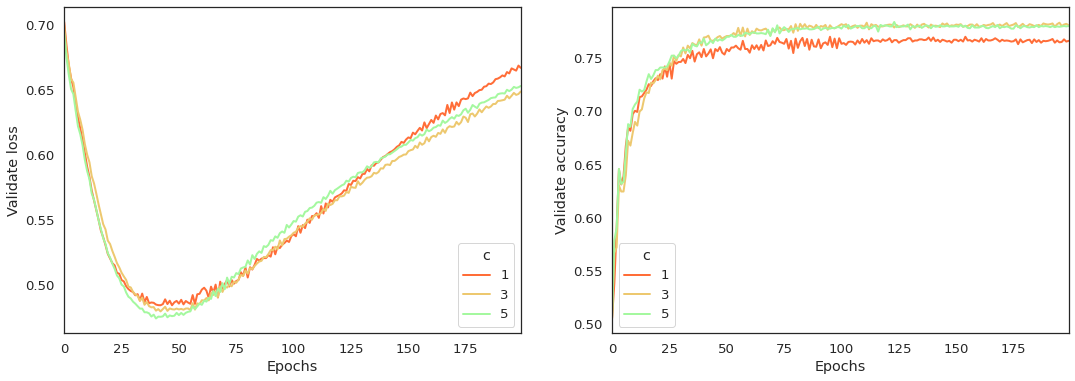

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6), sharex=False, sharey=False, )
ax1, ax2 = axes        



col = 'val_loss'
loss_mean = dfr.groupby(['c']).agg({col: lambda x:x.tolist()})[col].apply(lambda x: np.array(x).mean(axis=0)).apply(pd.Series).T
loss_std = dfr.groupby(['c']).agg({col: lambda x:x.tolist()})[col].apply(lambda x: np.array(x).std(axis=0)).apply(pd.Series).T
loss_mean.plot(ax=ax1, lw = 2, color = color) # ,ylim = (-2.55, -2) 
ax1.set_ylabel('Validate loss')
ax1.set_xlabel('Epochs')




col = 'val_accuracy'
acc_mean = dfr.groupby(['c']).agg({col: lambda x:x.tolist()})[col].apply(lambda x: np.array(x).mean(axis=0)).apply(pd.Series).T
acc_std = dfr.groupby(['c']).agg({col: lambda x:x.tolist()})[col].apply(lambda x: np.array(x).std(axis=0)).apply(pd.Series).T
acc_mean.plot(ax=ax2, lw = 2, color = color)
ax2.set_ylabel('Validate accuracy')
ax2.set_xlabel('Epochs')

plt.savefig('5FCV_valid.png', bbox_inches='tight', dpi=300)